In [1]:
import os
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

/home/enigma/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [ ]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

In [4]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [6]:
train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [7]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [8]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5,1,'(Label: D)')

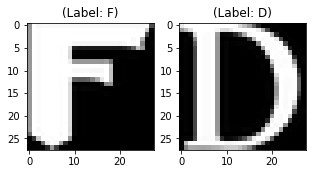

In [9]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [10]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [11]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [11]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [12]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [13]:
noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [14]:
batch_size = 128
epochs = 10
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [15]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [16]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [17]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         147584    
__________

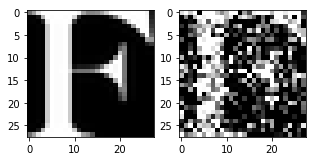

In [17]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(test_data[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

In [18]:
autoencoder_train = autoencoder.fit(x_train_noisy, train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid_noisy, valid_X))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 313s 7ms/step - loss: 0.0586 - val_loss: 0.0297
Epoch 2/10
48000/48000 [==============================] - 308s 6ms/step - loss: 0.0259 - val_loss: 0.0214
Epoch 3/10
48000/48000 [==============================] - 305s 6ms/step - loss: 0.0220 - val_loss: 0.0205
Epoch 4/10
48000/48000 [==============================] - 303s 6ms/step - loss: 0.0202 - val_loss: 0.0198
Epoch 5/10
48000/48000 [==============================] - 300s 6ms/step - loss: 0.0190 - val_loss: 0.0190
Epoch 6/10
48000/48000 [==============================] - 305s 6ms/step - loss: 0.0181 - val_loss: 0.0175
Epoch 7/10
48000/48000 [==============================] - 302s 6ms/step - loss: 0.0175 - val_loss: 0.0172
Epoch 8/10
 2688/48000 [>.............................] - ETA: 4:34 - loss: 0.0176

KeyboardInterrupt: 

In [19]:
autoencoder.save('notMnist.h5')

In [20]:
pred = autoencoder.predict(x_test_noisy)

Reconstruction of Noisy Test Images


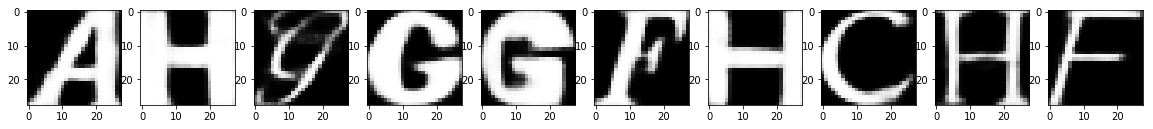

Originals Noisy Test Images


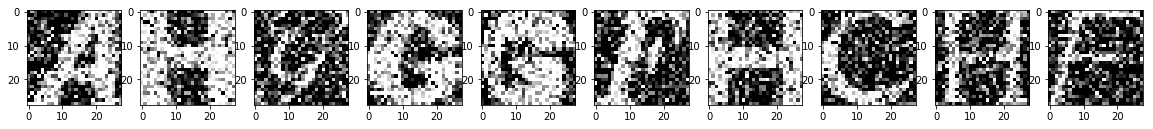

In [24]:
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

plt.figure(figsize=(20, 4))
print("Originals Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')  
plt.show()